In [372]:
from SimPEG import *
import simpegDCIP as DC
from ipywidgets import interact, IntSlider, FloatSlider, FloatText, ToggleButtons

In [221]:
%matplotlib inline

In [230]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 14

In [231]:
npad = 8
cs = 1.
hx = [(cs,npad, -1.3),(cs,100),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,50)]
mesh = Mesh.TensorMesh([hx, hy], "CN")
x = mesh.vectorCCx

In [232]:
circmap = Maps.CircleMap(mesh)
circmap.slope = 1e5
mapping = circmap
sighalf = 1e-3
rhohalf = 1./sighalf

In [233]:
xr = np.linspace(-40, 40, 20)
xz_A = Utils.ndgrid(xr, np.r_[-2.5])
xz_B = Utils.ndgrid(np.ones_like(xr)*19, np.r_[-2.5])
xz_M = Utils.ndgrid(xr, np.r_[-2.5])
xz_N = Utils.ndgrid(np.ones_like(xr)*-19, np.r_[-2.5])

In [364]:
def DipoleDipolefun(i):
    plt.figure(figsize=(10, 3))
    nmax = 8
    ntx = xr.size-2
    dxr = np.diff(xr)
    plt.plot(xr[:-1]+dxr*0.5, np.zeros_like(xr[:-1]), 'ko')
    plt.plot(xr[i]+dxr[i]*0.5, np.zeros(1), 'ro')
    # for i in range(ntx):
    if i < ntx-nmax+1:
        txmid = xr[i]+dxr[i]*0.5
        rxmid = xr[i+1:i+1+nmax]+dxr[i+1:i+1+nmax]*0.5
        mid = (txmid+rxmid)*0.5
        plt.plot(rxmid, np.zeros(rxmid.size), 'go')
        plt.plot(mid, np.arange(nmax)+1., 'bo')
        plt.plot(np.r_[txmid, mid[-1]], np.r_[0, nmax], 'k:')    
        for j in range(nmax):
            plt.plot(np.r_[rxmid[j], mid[j]], np.r_[0, j+1], 'k:')    

    else:
        txmid = xr[i]+dxr[i]*0.5
        rxmid = xr[i+1:ntx+1]+dxr[i+1:ntx+1]*0.5
        mid = (txmid+rxmid)*0.5    
        plt.plot((txmid+rxmid)*0.5, np.arange(mid.size)+1., 'bo')
        plt.plot(rxmid, np.zeros(rxmid.size), 'go')
        plt.plot(np.r_[txmid, mid[-1]], np.r_[0, mid.size], 'k:')    
        for j in range(ntx-i):
            plt.plot(np.r_[rxmid[j], mid[j]], np.r_[0, j+1], 'k:')    
    plt.xlabel("X (m)")
    plt.ylabel("N-spacing")    
    xlim(xr.min(), xr.max())
    ylim(nmax+1, -1)
    plt.show()
    return 

In [365]:
def getPseudoLocs(xr, ntx, nmax):
    dxr = np.diff(xr)
    xloc = []
    yloc = []    
    for i in range(ntx):
        if i < ntx-nmax+1:
            txmid = xr[i]+dxr[i]*0.5
            rxmid = xr[i+1:i+1+nmax]+dxr[i+1:i+1+nmax]*0.5
            mid = (txmid+rxmid)*0.5
            xloc.append(mid)
            yloc.append(np.arange(nmax)+1.)
        else:
            txmid = xr[i]+dxr[i]*0.5
            rxmid = xr[i+1:ntx+1]+dxr[i+1:ntx+1]*0.5
            mid = (txmid+rxmid)*0.5    
            xloc.append(mid)
            yloc.append(np.arange(mid.size)+1.)
    xlocvec = np.hstack(xloc)
    ylocvec = np.hstack(yloc)
    return np.c_[xlocvec, ylocvec]

In [366]:
dxr = np.diff(xr)
ntx, nmax = xr.size-2, 8
xzlocs = getPseudoLocs(xr, ntx, nmax)

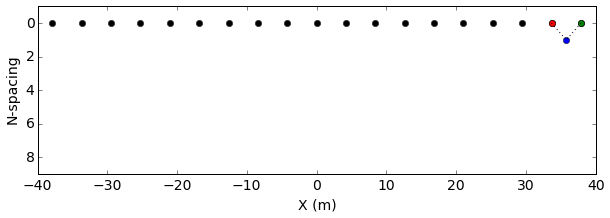

In [367]:
interact(DipoleDipolefun, i=IntSlider(min=0, max=ntx-1, step = 1, value=0))

In [238]:
txList = []
zloc = -2.5
for i in range(ntx):
    A = np.r_[xr[i]+dxr[i]*0.5, zloc]
    B = np.r_[mesh.vectorCCx.min(), zloc]   
    if i < ntx-nmax+1:
        M = np.c_[xr[i+1:i+1+nmax], np.ones(nmax)*zloc]        
        N = np.c_[xr[i+2:i+2+nmax], np.ones(nmax)*zloc]                
    else:
        M = np.c_[xr[i+1:ntx+1], np.ones(ntx-i)*zloc]        
        N = np.c_[xr[i+2:i+2+nmax], np.ones(ntx-i)*zloc]                
    rx = DC.RxDipole(M, N)
    src = DC.SrcDipole([rx], A, B)
    txList.append(src)

In [239]:
survey = DC.SurveyDC(txList)
problem = DC.ProblemDC_CC(mesh, mapping = mapping)
problem.pair(survey)

In [240]:
from pymatsolver import MumpsSolver
problem.Solver = MumpsSolver

In [422]:
sigblk, sighalf = 2e-2, 2e-3
xc, yc, r = -15, -8, 4
mtrue = np.r_[np.log(sigblk), np.log(sighalf), xc, yc, r]
dtrue = survey.dpred(mtrue) 
perc = 0.1
floor = np.linalg.norm(dtrue)*1e-3
uncert = np.random.randn(survey.nD)*perc + floor
dobs = dtrue + uncert 

In [429]:
def DC2Dfwdfun(mesh, rhohalf, rhoblk, xc, yc, r, dobs, uncert, predmis):
    sighalf, sigblk = 1./rhohalf, 1./rhoblk
    m0 = np.r_[np.log(sighalf), np.log(sighalf), xc, yc, r]
    dini = survey.dpred(m0)
    mtrue = np.r_[np.log(sigblk), np.log(sighalf), xc, yc, r]
    dpred  = survey.dpred(mtrue)
    xi, yi = np.meshgrid(np.linspace(xr.min(), xr.max(), 120), np.linspace(1., nmax, 100))
    appres = dpred/dini/sighalf
    appresobs = dobs/dini/sighalf
    pred = griddata(xzlocs[:,0], xzlocs[:,1], appres, xi, yi, interp='linear')
    obs = griddata(xzlocs[:,0], xzlocs[:,1], appresobs, xi, yi, interp='linear')
    fig = plt.figure(figsize = (12, 8))
    ax1 = plt.subplot(311)
    dat1 = mesh.plotImage(np.log10(1./(mapping*mtrue)), ax=ax1, clim=(0, 3), grid=True, gridOpts={'color':'k', 'alpha':0.5})
    cb1 = plt.colorbar(dat1[0], ticks=np.linspace(0, 3, 5), ax=ax1, format="$10^{%4.1f}$")
    cb1.set_label("Resistivity (ohm-m)")
    ax1.set_ylim(-30, 0.)
    ax1.set_xlim(-40, 40)
    ax1.set_xlabel("")
    ax1.set_ylabel("Depth (m)")    
    ax2 = plt.subplot(312)
    dat2 = ax2.contourf(xi, yi, obs, 10)
    ax2.contour(xi, yi, obs, 10, colors='k', alpha=0.5)
    ax2.plot(xzlocs[:,0], xzlocs[:,1],'k.', ms = 3)
    cb2 = plt.colorbar(dat2, ax=ax2, ticks=np.linspace(appresobs.min(), appresobs.max(), 5), format="%4.1f")
   
    cb2.set_label("Apparent Resistivity \n (ohm-m)")
    ax2.set_ylim(nmax+1, 0.)
    ax2.set_ylabel("N-spacing")    
    ax2.text(-38, 7, "Observed")
    
    ax3 = plt.subplot(313)
    if predmis=="pred":
        dat3 = ax3.contourf(xi, yi, pred, 10)
        ax3.contour(xi, yi, pred, 10, colors='k', alpha=0.5)
        ax3.plot(xzlocs[:,0], xzlocs[:,1],'k.', ms = 3)
        cb3 = plt.colorbar(dat3, ax=ax3, ticks=np.linspace(appres.min(), appres.max(), 5),format="%4.0f")
        cb3.set_label("Apparent Resistivity \n (ohm-m)")
        ax3.text(-38, 7, "Predicted")
    elif predmis=="mis":
        mis = (appresobs-appres)/(0.1*appresobs)
        Mis = griddata(xzlocs[:,0], xzlocs[:,1], mis, xi, yi, interp='linear')        
        dat3 = ax3.contourf(xi, yi, Mis, 10)
        ax3.contour(xi, yi, Mis, 10, colors='k', alpha=0.5)
        ax3.plot(xzlocs[:,0], xzlocs[:,1],'k.', ms = 3)
        cb3 = plt.colorbar(dat3, ax=ax3, ticks=np.linspace(mis.min(), mis.max(), 5), format="%4.2f")
        cb3.set_label("Normalized misfit")
        ax3.text(-38, 7, "Misifit")    
    ax3.set_ylim(nmax+1, 0.)
    ax3.set_ylabel("N-spacing")    
    ax3.set_xlabel("Distance (m)")    
    plt.show()
    return True

In [430]:
DC2Dfwd = lambda rhohalf, rhosph, xc, zc, r, predmis: DC2Dfwdfun(mesh, rhohalf, rhosph, xc, zc, r, dobs, uncert, predmis)
# DC2Dfwdfun(mesh, 1000., 1e1, 0., -9, 4, dobs, uncert, "pred")

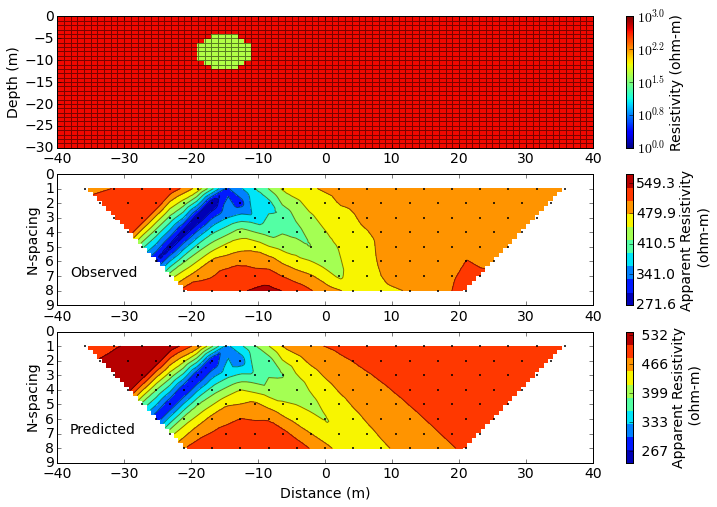

True

In [431]:
interact(DC2Dfwd,
         rhohalf = FloatSlider(min=0, max=1000, step=1, value = 500),
         rhosph = FloatSlider(min=0, max=1000, step=1, value = 50),
         xc = FloatSlider(min=-40, max=40, step=1, value =  -15),
         zc = FloatSlider(min= -20, max=0, step=1, value =  -8),
         r = FloatSlider(min= 0, max=15, step=0.5, value = 4),
         predmis = ToggleButtons(options=['pred','mis'])         
        )